In [2]:
#  Import Libraries
import os
import matplotlib.pyplot as plt

import findspark
from pyspark.sql import SparkSession

import seaborn as sns
import pandas as pd
import numpy as np

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)  # For ValueWarning and other user warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from lib_file import lib_path
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
print(sc.version)

3.5.1


In [4]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [5]:
#Starting the session
spark = SparkSession.builder.appName('Global_Temprature').getOrCreate()

In [6]:
#  Data Loading with spark
data_monthly = spark.read.csv('data_monthly.csv', inferSchema = True, header = True)

In [7]:
data_monthly.printSchema()

root
 |-- month_start: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)



In [8]:
data_monthly.show(10)

+-----------+------------------+
|month_start|AverageTemperature|
+-----------+------------------+
| 1743-11-01| 4.882423512747881|
| 1743-12-01| 4.882423512747881|
| 1744-01-01| 4.882423512747881|
| 1744-02-01| 4.882423512747881|
| 1744-03-01| 4.882423512747881|
| 1744-04-01| 9.737433427762047|
| 1744-05-01|12.685514164305946|
| 1744-06-01|16.868296033994334|
| 1744-07-01|18.844524079320134|
| 1744-08-01|18.844524079320134|
+-----------+------------------+
only showing top 10 rows



In [10]:
# Model-Training With PySpark
# AutoARIMA Model 
%%time

import pmdarima as pm
from pyspark.sql import SparkSession


data_monthly_pd = data_monthly.toPandas()

# target column 
time_series_data = data_monthly_pd['AverageTemperature']

# Fit the auto ARIMA model
auto_arima_model = pm.auto_arima(time_series_data,
                                 seasonal=True,  # Enables SARIMA if seasonality is detected
                                 m=12,           # Seasonal period 12 months
                                 d=None,         # Let auto_arima decide the differencing
                                 stepwise=True,  # Stepwise search to reduce computation time
                                 suppress_warnings=True,  # Suppress warning messages
                                 trace=True)  # Enables detailed output of the model search

# Print the summary of the model
print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9486.763, Time=27.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16353.386, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13623.370, Time=4.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16351.397, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=9996.819, Time=20.09 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=22.01 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=9486.386, Time=49.72 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=106.36 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=9382.751, Time=72.75 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=9575.690, Time=80.24 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=9524.560, Time=47.77 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=54.09 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=10080.778, Time=72.66 sec
 ARIMA(2,1,3)(2,0,2)[12]

In [11]:
# AutoSARIMA Model
%%time

import pmdarima as pm

time_series_data = data_monthly_pd['AverageTemperature']

# Fit the auto SARIMA model
auto_sarima_model = pm.auto_arima(time_series_data, 
                                  seasonal=True,  # Enables SARIMA
                                  m=12,           # Seasonal period (12 for monthly data)
                                  d=None,         # Let auto_arima decide the differencing
                                  D=None,         # Let auto_arima decide seasonal differencing
                                  start_p=1, start_q=1,  # Initial guess for AR and MA terms
                                  max_p=3, max_q=3,      # Limits for AR and MA terms
                                  start_P=1, start_Q=1,  # Initial guess for seasonal AR and MA terms
                                  max_P=2, max_Q=2,      # Limits for seasonal AR and MA terms
                                  stepwise=True,         # Stepwise search to reduce computation time
                                  suppress_warnings=True,  # Suppress warnings
                                  trace=True)  # Enable detailed output of the model search

# Print the summary of the model
print(auto_sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=14.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16353.386, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=4.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13623.370, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16351.397, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=14614.244, Time=1.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=9969.852, Time=11.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=11353.321, Time=5.44 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=9968.848, Time=28.82 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=10594.001, Time=11.60 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=9972.745, Time=28.25 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=9969.199, Time=30.47 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=10020.939, Time=17.28 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=32.03 sec
 ARIMA(0,1,2)(2,0,1

In [12]:
# Model-1 Arima
# Extract the best ARIMA parameters (p, d, q)
best_order = auto_arima_model.order
print("ARIMA (p, d, q):", best_order)


ARIMA (p, d, q): (2, 1, 3)


In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Convert the AverageTemperature Spark DataFrame to
data_pandas = data_monthly.select("AverageTemperature").toPandas()

# Fit the ARIMA model with the best (p, d, q) parameters
arima_model = ARIMA(data_pandas['AverageTemperature'], order=best_order) 
arima_result = arima_model.fit()

#ARIMA model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 3239
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4922.742
Date:                Tue, 10 Dec 2024   AIC                           9857.485
Time:                        12:33:45   BIC                           9893.981
Sample:                             0   HQIC                          9870.562
                               - 3239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7270      0.002   1036.954      0.000       1.724       1.730
ar.L2         -0.9936      0.002   -605.673      0.000      -0.997      -0.990
ma.L1         -1.9861      0.009   -232.724      0.0

In [14]:
# Model-2 SARIMA 
# Extracting the seasonal order from auto ARIMA model
best_seasonal_order = auto_sarima_model.seasonal_order  

#SARIMA seasonal order (P, D, Q, m)
print("SARIMA seasonal order (P, D, Q, m):", best_seasonal_order)


SARIMA seasonal order (P, D, Q, m): (2, 0, 2, 12)


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model with the best (p, d, q) and seasonal parameters
sarima_model = SARIMAX(data_pandas['AverageTemperature'],  # 'AverageTemperature' as the series
                       order=best_order,  # (p, d, q)
                       seasonal_order=best_seasonal_order)  # (P, D, Q, m)

# Fit the model
sarima_result = sarima_model.fit()

# Print the summary of the SARIMA model
print(sarima_result.summary())

                                        SARIMAX Results                                        
Dep. Variable:                      AverageTemperature   No. Observations:                 3239
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -4626.933
Date:                                 Tue, 10 Dec 2024   AIC                           9273.867
Time:                                         12:35:29   BIC                           9334.694
Sample:                                              0   HQIC                          9295.661
                                                - 3239                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6287      0.008    204.572      0.000       1.613       1

In [16]:
# Result Analysis: ARIMA and SARIMA with PySpark
# ARIMA Result

from sklearn.metrics import mean_squared_error, r2_score

data_pandas = data_monthly.toPandas()

# keep only the numeric column for modeling
train_size = int(len(data_pandas) * 0.8)

train_data = data_pandas[:train_size]['AverageTemperature']
test_data = data_pandas[train_size:]['AverageTemperature']

# Fit the auto_arima model on the training data
auto_arima_model.fit(train_data)

# Forecast the test data
forecast = auto_arima_model.predict(n_periods=len(test_data))

# Calculate evaluation metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, forecast)

# Display results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 1.0359227561331057
Root Mean Squared Error (RMSE): 1.0178029063296614
R-squared (R²): 0.9462902030191617


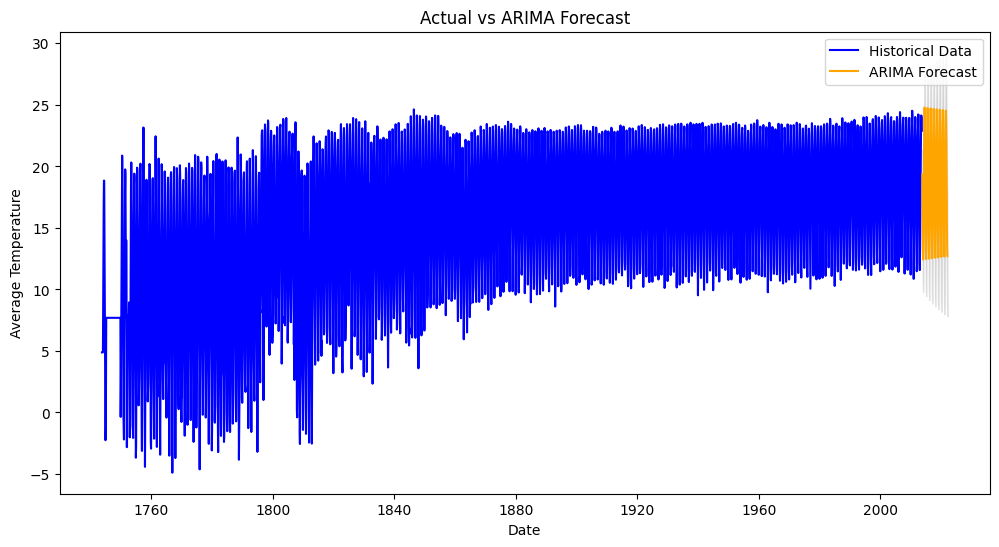

In [17]:
# Convert 'month_start' to datetime
data_pandas['month_start'] = pd.to_datetime(data_pandas['month_start'])

# Set 'month_start' as the index 
data_pandas.set_index('month_start', inplace=True)

# Fit ARIMA model using best_order 
arima_model = ARIMA(data_pandas['AverageTemperature'], order=(2, 1, 4))  
arima_result = arima_model.fit()

# Set forecast horizon 
n_periods = 100

# Forecast with ARIMA model
arima_forecast = arima_result.get_forecast(steps=n_periods)
arima_conf_int = arima_forecast.conf_int()

# Create a time index for the forecast
arima_forecast_index = pd.date_range(data_pandas.index[-1], periods=n_periods + 1, freq='M')[1:]

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data_pandas.index, data_pandas['AverageTemperature'], label='Historical Data', color='blue')

# Plot ARIMA forecast
plt.plot(arima_forecast_index, arima_forecast.predicted_mean, label='ARIMA Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(arima_forecast_index, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='gray', alpha=0.2)

# Add labels and title
plt.title('Actual vs ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(False)
plt.show()

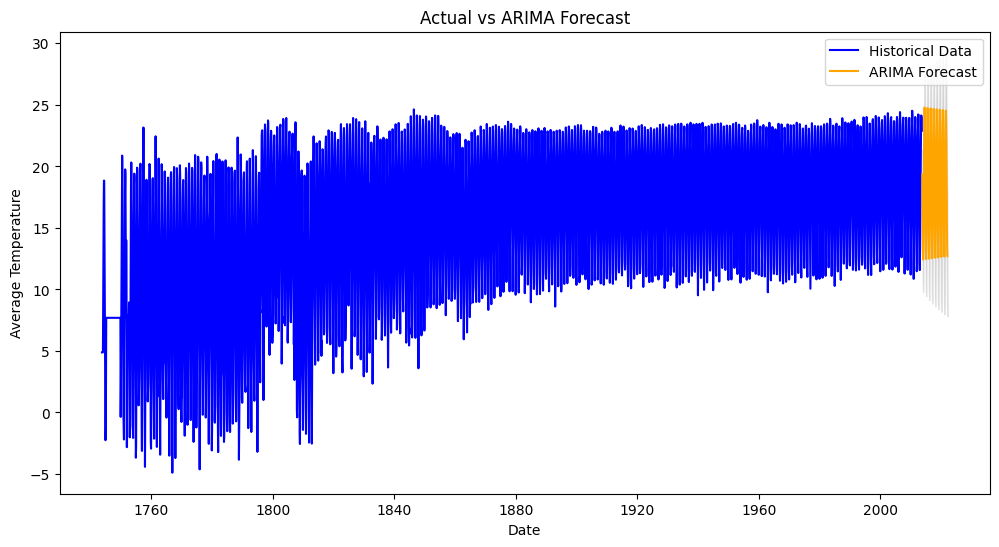

In [18]:
# SARIMA Result
from pyspark.sql.functions import col, to_date
from statsmodels.tsa.arima.model import ARIMA

# Convert 'month_start' to date type 
data_monthly = data_monthly.withColumn('month_start', to_date(col('month_start')))

# Convert DataFrame to pandas DataFrame for ARIMA modeling
data_monthly_pd = data_monthly.toPandas()

# Ensure 'month_start' is in datetime format and set it as the index
data_monthly_pd['month_start'] = pd.to_datetime(data_monthly_pd['month_start'])
data_monthly_pd.set_index('month_start', inplace=True)

# Fit ARIMA model using the best_order 
arima_model = ARIMA(data_monthly_pd['AverageTemperature'], order=(2, 1, 4))
arima_result = arima_model.fit()

# Set forecast horizon (e.g., next 100 months)
n_periods = 100

# Forecast with ARIMA model
arima_forecast = arima_result.get_forecast(steps=n_periods)
arima_conf_int = arima_forecast.conf_int()

# Create a time index for the forecast
arima_forecast_index = pd.date_range(data_monthly_pd.index[-1], periods=n_periods + 1, freq='M')[1:]

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data_monthly_pd.index, data_monthly_pd['AverageTemperature'], label='Historical Data', color='blue')

# Plot ARIMA forecast
plt.plot(arima_forecast_index, arima_forecast.predicted_mean, label='ARIMA Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(arima_forecast_index, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='gray', alpha=0.2)

# Add labels and title
plt.title('Actual vs ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(False)
plt.show()


In [19]:
# Convert 'month_start' to a PySpark date column
data_monthly = data_monthly.withColumn('month_start', to_date(col('month_start')))

data_monthly_pd = data_monthly.toPandas()

# 'month_start' to datetime in pandas and set it as the index
data_monthly_pd['month_start'] = pd.to_datetime(data_monthly_pd['month_start'])
data_monthly_pd.set_index('month_start', inplace=True)

# Split the data into training and testing sets (80-20 split)
train_size = int(len(data_monthly_pd) * 0.8)
train_data = data_monthly_pd[:train_size]
test_data = data_monthly_pd[train_size:]

# Fit the SARIMA model
sarima_model = SARIMAX(train_data['AverageTemperature'], order=best_order, seasonal_order=best_seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the test data period
forecast = sarima_result.forecast(steps=len(test_data))

# Calculate metrics
mse = mean_squared_error(test_data['AverageTemperature'], forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_data['AverageTemperature'], forecast)

# Display results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 0.39
Root Mean Squared Error (RMSE): 0.62
R-squared (R²): 0.98


In [20]:
# Showing forcasting with sarima
# Get the predicted mean temperatures from the ARIMA forecast
arima_predicted_mean = arima_forecast.predicted_mean

# Combine the forecast index and predicted values into a DataFrame
arima_forecasted_data = pd.DataFrame({
    "Date": arima_forecast_index,
    "Predicted_AverageTemperature": arima_predicted_mean
})

# Display the top 20 predicted values
print(arima_forecasted_data.head(20))


                 Date  Predicted_AverageTemperature
2013-10-01 2013-10-31                     19.340033
2013-11-01 2013-11-30                     15.793399
2013-12-01 2013-12-31                     13.411852
2014-01-01 2014-01-31                     12.426175
2014-02-01 2014-02-28                     13.099098
2014-03-01 2014-03-31                     15.248714
2014-04-01 2014-04-30                     18.297646
2014-05-01 2014-05-31                     21.428127
2014-06-01 2014-06-30                     23.801338
2014-07-01 2014-07-31                     24.782169
2014-08-01 2014-08-31                     24.109184
2014-09-01 2014-09-30                     21.964303
2014-10-01 2014-10-31                     18.923629
2014-11-01 2014-11-30                     15.802712
2014-12-01 2014-12-31                     13.437809
2015-01-01 2015-01-31                     12.461804
2015-02-01 2015-02-28                     13.134845
2015-03-01 2015-03-31                     15.275000
2015-04-01 2

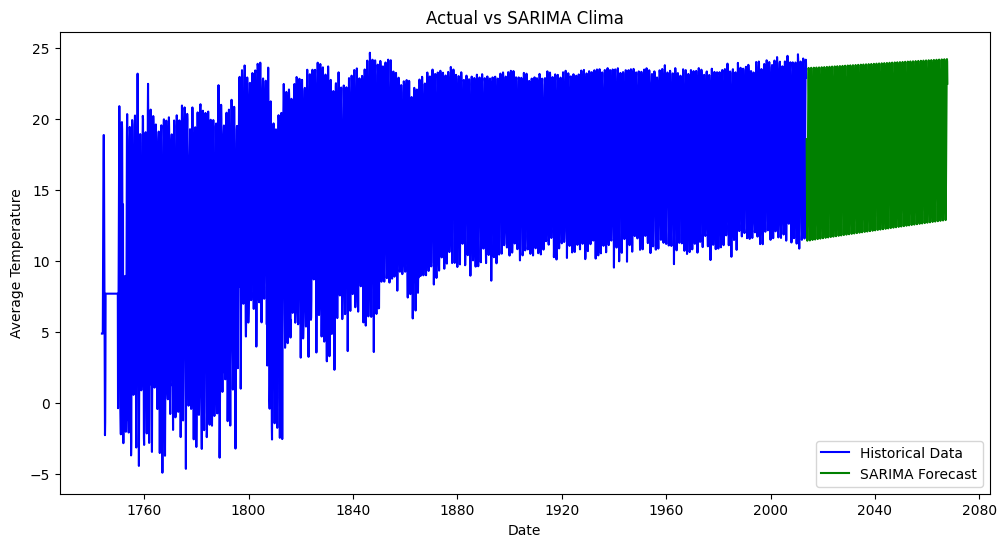

In [22]:
# Ploting graph with sarima
if hasattr(test_data, "toPandas"):  # It's a PySpark DataFrame
    test_data_pd = test_data.toPandas()
else:  # It's already a Pandas DataFrame
    test_data_pd = test_data

# Generate SARIMA forecast 
sarima_forecast = sarima_result.get_forecast(steps=len(test_data_pd['AverageTemperature']))
sarima_conf_int = sarima_forecast.conf_int()

# Create the time index for SARIMA forecast
sarima_forecast_index = pd.date_range(data_pandas.index[-1], periods=len(test_data_pd['AverageTemperature']) + 1, freq='M')[1:]

# Plot the data
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data_pandas.index, data_pandas['AverageTemperature'], label='Historical Data', color='blue')

# Plot SARIMA forecast
plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, label='SARIMA Forecast', color='green')

# Add labels and title
plt.title('Actual vs SARIMA Clima')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(False)
plt.show()


In [23]:
#  Data Splitting
#converting to Pandas DataFrame
data_pandas = data_monthly.select("month_start", "AverageTemperature").toPandas()

data_pandas['month_start'] = pd.to_datetime(data_pandas['month_start'])
data_pandas.set_index('month_start', inplace=True)

# assuming that 'AverageTemperature' is the target
# Adding 'month' and 'year' as features
data_pandas['month'] = data_pandas.index.month
data_pandas['year'] = data_pandas.index.year

#Prepare X (features) and y (target)
X = data_pandas[['month', 'year']]  # Adding month and year as features
y = data_pandas['AverageTemperature']

#Split the data into training and testing set(80% train, 20% test)
train_size = int(0.8 * len(data_pandas))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [26]:
# Model-Training With XGBoost and LinearRegression
# Model-3 XGBoost 

%%time
import xgboost as xgb

#Convert the data to DMatrix format (required by XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#Set up hyperparameters for XGBoost 
params = {
    'objective': 'reg:squarederror',  # For regression
    'eval_metric': 'rmse',            # Evaluation metric (Root Mean Squared Error)
    'max_depth': 6,                   # Maximum depth of the tree
    'learning_rate': 0.1,             # Learning rate
    'n_estimators': 100               # Number of boosting rounds
}

# Training the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make prediction on the test data
y_pred = xgb_model.predict(dtest)

#Evaluate the model (using RMSE and R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.22693269650565298
Root Mean Squared Error (RMSE): 0.4763745338550886
R-squared (R²): 0.9882341526088971
CPU times: total: 109 ms
Wall time: 14.2 s


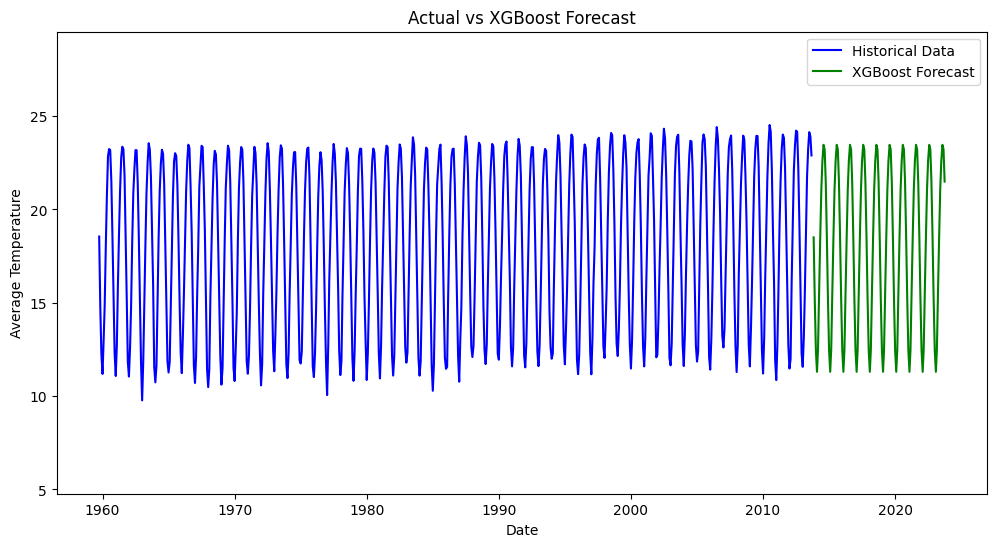

In [27]:
#Prepare future dates for the forecast (next 12 periods)
n_periods = 120  # Number of future periods you want to forecast
forecast_dates = pd.date_range(start=X_test.index[-1], periods=n_periods + 1, freq='M')[1:]

# Create future feature data (month and year)
future_features = pd.DataFrame({
    'month': forecast_dates.month,
    'year': forecast_dates.year
})

#Make future predictions using the trained XGBoost model
X_future = future_features
future_pred = xgb_model.predict(xgb.DMatrix(X_future))

#Prepare the forecast data for plotting
future_forecast = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted': future_pred
})

#Plot the historical and forecasted data
plt.figure(figsize=(12, 6))

# Plot historical data 
plt.plot(X_test.index, y_test, label='Historical Data', color='blue')

# Plot future predictions
plt.plot(future_forecast['Date'], future_forecast['Predicted'], label='XGBoost Forecast', color='green')

# Adjust y-axis range
plt.ylim([y_test.min() - 5, y_test.max() + 5])

# Add labels, title, and legend
plt.title('Actual vs XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(False)
plt.show()


In [28]:
#Prepare the DataFrame for predictions with Date range
forecast_dates = pd.date_range(start='2013-10-01', periods=20, freq='MS')  # Adjust the start date and periods
future_features = pd.DataFrame({
    'month': forecast_dates.month,
    'year': forecast_dates.year
})

# Predict using the trained XGBoost model
X_future = future_features 
future_pred = xgb_model.predict(xgb.DMatrix(X_future))

#the DataFrame with 'Date' and 'Predicted_AverageTemperature'
future_forecast = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_AverageTemperature': future_pred
})

#Format and print the DataFrame like your desired output
future_forecast['Date'] = future_forecast['Date'].dt.strftime('%Y-%m-%d')  # Format the Date column

# Printing the DataFrame
print(future_forecast)


          Date  Predicted_AverageTemperature
0   2013-10-01                     18.505390
1   2013-11-01                     15.206614
2   2013-12-01                     12.456279
3   2014-01-01                     11.301189
4   2014-02-01                     12.481664
5   2014-03-01                     15.587275
6   2014-04-01                     18.445147
7   2014-05-01                     21.069746
8   2014-06-01                     22.612041
9   2014-07-01                     23.463730
10  2014-08-01                     23.213923
11  2014-09-01                     21.495304
12  2014-10-01                     18.505390
13  2014-11-01                     15.206614
14  2014-12-01                     12.456279
15  2015-01-01                     11.301189
16  2015-02-01                     12.481664
17  2015-03-01                     15.587275
18  2015-04-01                     18.445147
19  2015-05-01                     21.069746


In [29]:
# Model-4 LinearRegression

from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import unix_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

#Convert the 'month_start' column to a numerical format
data_monthly = data_monthly.withColumn("month_start_numeric", unix_timestamp("month_start"))

#Prepare the feature vector using the numeric column
vector_assembler = VectorAssembler(
    inputCols=["month_start_numeric"],  
    outputCol="features"
)

# Transform data to include the features column
data_transformed = vector_assembler.transform(data_monthly)

#Spliting data into training and testing sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="AverageTemperature")  # Use AverageTemperature as label
lr_model = lr.fit(train_data)

#Make predictions on the test data
predictions = lr_model.transform(test_data)

# Convert predictions and actual values to pandas for easier MSE calculation
predictions_pd = predictions.select("prediction", "AverageTemperature").toPandas()

# Calculate MSE and RMSE
mse = mean_squared_error(predictions_pd["AverageTemperature"], predictions_pd["prediction"])
rmse = mse**0.5  # or you can use sklearn's `mean_squared_error` to directly compute RMSE

#Evaluate the model using R²
evaluator_r2 = RegressionEvaluator(
    labelCol="AverageTemperature", predictionCol="prediction", metricName="r2"
)
r2 = evaluator_r2.evaluate(predictions)

# Step 8: Display evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 32.15857722418334
Root Mean Squared Error (RMSE): 5.6708533065300974
R-squared (R²): 0.16893635241560556


---